<a href="https://colab.research.google.com/github/vivek86-ai/Inception_CIFAR10/blob/master/Inception_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Import Keras
import keras

In [0]:
#import necessary libraries
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.vgg16 import VGG16, preprocess_input

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Flatten, MaxPooling2D, Dropout, UpSampling2D, BatchNormalization
from keras import models
from keras import optimizers

from keras.preprocessing import image
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
import numpy as np

from PIL import Image

import cv2



In [13]:
#Map your google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Datasets --> CIFAR10

In [0]:
#Load CIFAR10 datasets
(x_train, y_train),(x_test, y_test) = cifar10.load_data()

In [0]:
#Normalize the x-train, x_test
x_train = x_train/255.
x_test = x_test/255.

In [16]:
#Cheking x_train, x_test shape
print("x_train shape- -> ", x_train.shape)
print("x_test shape -> ", x_test.shape)

x_train shape- ->  (50000, 32, 32, 3)
x_test shape ->  (10000, 32, 32, 3)


In [0]:
#Encoding labels i.e. y_train & y_test
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

#Building Inception Model

In [18]:
#Making include_top = False as we have only 10 labels
inception_Base = InceptionV3(include_top = False, input_shape = (200,200,3), weights = "imagenet")
inception_Base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 99, 99, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_97 (BatchNo (None, 99, 99, 32)   96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 99, 99, 32)   0           batch_normalization_97[0][0]     
_______________________________________________________________________________________

In [19]:
from keras.utils import plot_model
plot_model(inception_Base, show_shapes = True, to_file = "Inception.png")

In [0]:
#Building Model
model = Sequential()

#Upsampling 
model.add(UpSampling2D((2,2)))
model.add(UpSampling2D((2,2)))
model.add(UpSampling2D((2,2)))

#The Inception we have created 
model.add(inception_Base)

#Flattening the model so that we cann add FNN
model.add(Flatten())

#Adding Dense Layer of 128 neurons  and activation 'relu'
model.add(Dense(128, activation='relu'))

#Adding dropout. Dropout acts as regulariser
model.add(Dropout(0.2))

#Adding BatchNormalization
model.add(BatchNormalization())

#Adding one more layer of neuron 62 & relu activation
model.add(Dense(62, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

#Final layer with softmax activation
model.add(Dense(10, activation='softmax'))

#Compiling the model
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])


In [0]:
#Initializing Callbacks
#Applying concept for saving best model, if you go for multiple epochs
#EarlyStopping - It will stop the training , if there is no improvent in val_loss and save compution
from datetime import datetime
from keras.callbacks import ModelCheckpoint



checkpoint = ModelCheckpoint(filepath = 'drive/My Drive/VGG_Data/Inception_Model.h5',
                             verbose = 1,
                             save_best_only = True)
earlystopping = keras.callbacks.EarlyStopping(monitor ="val_loss", mode = "min", verbose=1)

In [0]:
callbacks = [checkpoint, earlystopping]

In [29]:
#Fitting Model
start =datetime.now()

history = model.fit(x_train, y_train, epochs = 1, batch_size=64, validation_data=(x_test, y_test), callbacks = callbacks)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 1632s 33ms/step - loss: 0.1559 - accuracy: 0.9476 - val_loss: 0.0526 - val_accuracy: 0.9831

Epoch 00001: val_loss improved from inf to 0.05257, saving model to drive/My Drive/VGG_Data/Inception_Model.h5
Training completed in time:  0:27:14.275255


In [0]:
 #Loading Model from drive
model1 = load_model("drive/My Drive/VGG_Data/Inception_Model.h5")

In [0]:
from matplotlib.pyplot import imshow
from google.colab.patches import cv2_imshow
from skimage import io

In [81]:
input_img = io.imread("cat.jpg")
input_img.shape

(300, 400, 3)

In [82]:
#input_img = io.imread("cat.jpg")
#input_img = cv2.resize(input_img,dsize =  (128,128), interpolation = cv2.INTER_CUBIC)

#Loading imagefrom drive and resize to (32,32) from (300,400)
img = image.load_img("cat.jpg", target_size=(32, 32))
img = image.img_to_array(img)
img.shape

(32, 32, 3)

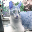

In [83]:
cv2_imshow(img)

In [84]:
img = np.expand_dims(img, axis=0)
img.shape

(1, 32, 32, 3)

In [0]:
#Preprocessing the image and predict the same
img = preprocess_input(img)
preds = model1.predict(img)

In [86]:
preds

array([[5.6263391e-31, 9.6396095e-01, 0.0000000e+00, 6.1974716e-03,
        2.9841602e-02, 1.0864323e-27, 1.5387385e-21, 2.3748916e-24,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [87]:
if preds.argmax() == 0:
  print("Airplane")
elif preds.argmax() == 1:
  print("Automobile")
elif preds.argmax() == 2:
  print("bird")
elif preds.argmax() == 3:
  print("cat")
elif preds.argmax() == 4:
  print("dear")
elif preds.argmax() == 5:
  print("dog")
elif preds.argmax() == 6:
  print("frog")
elif preds.argmax() == 7:
  print("horse")
elif preds.argmax() == 8:
  print("ship")
else:
  print("truck")


Automobile
